# Data Collection

## Scraping from YouTube

In [1]:
from pytube import YouTube
yt = YouTube('https://www.youtube.com/watch?v=U5fX9tbA_Tg')

In [2]:
print(yt.title)
print(yt.thumbnail_url)

Live from Space: James Zooms w/ NASA Astronauts
https://i.ytimg.com/vi/U5fX9tbA_Tg/maxresdefault.jpg


In [3]:
# streams available to download
yt.streams.all()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">,
 <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="399" mime_type="video/mp4" res="None" fps="30fps" vcodec="av01.0.08M.08" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="398" mime_type="video/mp4" res="None" fps="30fps" vcodec="av01.0.05M.08" progressive="False" type="video">

In [4]:
import pandas as pd
videos = pd.read_csv('youtube_videos.csv')
videos.head()

,Genre,Show,Title,Description,link,start,end,class,split_length,Comments,length
0,News,Last Week Tonight with John Oliver,Coronavirus VIII: Prisons & Jails (HBO),Oliver talking to camera about COVID-19,https://youtu.be/MuxnH0VAkAM,0:00,1:44,organic,5,NaN,1:44
1,NaN,NaN,NaN,CBS news feed on COVID-19 replay,NaN,1:45,2:09,electronic,5,NaN,0:24
2,NaN,NaN,NaN,Oliver talking to camera about prison congestion,NaN,2:13,3:04,organic,5,NaN,0:51
3,NaN,NaN,NaN,CBS 2018 on small prison cells replay,NaN,3:05,3:20,electronic,5,NaN,0:15
4,NaN,NaN,NaN,Oliver talking to camera about difficulty in s...,NaN,3:21,3:50,organic,5,NaN,0:29


In [7]:
import os
from pydub import AudioSegment
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

# convert youtube time format into seconds
def get_sec(time_str):
    time_format = time_str.count(':')
    if (time_format == 1): # MM:SS
        m, s = time_str.split(':')
        return int(m) * 60 + int(s)
    else: # HH:MM:SS
        h, m, s = time_str.split(':')
        return int(h) * 3600 + int(m) * 60 + int(s)

# get filename without extension
def path_leaf(path):
    head, tail = os.path.split(path)
    return os.path.splitext(tail)[0] or os.path.basename(head)

# Function to remove spaces  
# and convert into camel case 
def convert(s): 
    if(len(s) == 0): 
        return
    s1 = '' 
    s1 += s[0].upper() 
    for i in range(1, len(s)): 
        if (s[i] == ' '): 
            s1 += s[i + 1].upper() 
            i += 1
        elif(s[i - 1] != ' '): 
            s1 += s[i]  
    return s1  

# read csv to generate dataset
current_video = ''
src_folder = "youtube/"
dst_folder = 'youtube/clips/'
item = 0
dst = ""

for index, row in videos.iterrows():
    
    # download video
    print("LINK:", row['link'])
    if('http' in str(row['link'])): # new link encountered
        current_video = row['link']
        print('parsing video', current_video)
        
        # download audio in original format
        src = YouTube(row['link']
            ).streams.filter(file_extension='mp4', only_audio=True).first( # get mp4 audio stream
            ).download(output_path=src_folder, filename=convert(row['Show'])+"-"+str(index)) # write stream to file
        print('video downloaded to', src)
        
        # lossless conversion of mp4 to wav
        dst = src_folder + path_leaf(src) + '.wav'
        sound = AudioSegment.from_file(src)
        sound.export(dst, format="wav")

    # determine time region for cuts
    print("DEST:", dst)
    splice_len = row['split_length']
    start_time = get_sec(row['start'])
    end_time = get_sec(row['end'])
    
    # make cuts by split length
    for i in range(start_time, end_time - splice_len, splice_len):
        print('clip #:', item, 'clip start:', i, 'clip end:', i + splice_len, 'video start:', start_time, 'video end:', end_time)
        ffmpeg_extract_subclip(dst, i, end_time if (i + splice_len > end_time) else (i + splice_len), targetname=dst_folder + path_leaf(src)+str(item)+'-'+str(i)+'.wav')
        item += 1

LINK: https://youtu.be/MuxnH0VAkAM
parsing video https://youtu.be/MuxnH0VAkAM
video downloaded to /Users/rramnauth/Desktop/audio-feature-extraction/notebooks/youtube/LastWeekTonightWithJohnOliver-0.mp4
DEST: youtube/LastWeekTonightWithJohnOliver-0.wav
clip #: 0 clip start: 0 clip end: 5 video start: 0 video end: 104
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1 clip start: 5 clip end: 10 video start: 0 video end: 104
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2 clip start: 10 clip end: 15 video start: 0 video end: 104
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 3 clip start: 15 clip end: 20 video start: 0 video end: 104
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 4 clip start: 20 clip end: 25 video start: 0 video end: 104
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 5 clip start: 25 clip end: 30 video start: 0 video end: 10

Moviepy - Command successful
LINK: https://youtu.be/kxatzHnl7Q8
parsing video https://youtu.be/kxatzHnl7Q8
video downloaded to /Users/rramnauth/Desktop/audio-feature-extraction/notebooks/youtube/LastWeekTonightWithJohnOliver-8.mp4
DEST: youtube/LastWeekTonightWithJohnOliver-8.wav
clip #: 57 clip start: 1 clip end: 6 video start: 1 video end: 300
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 58 clip start: 6 clip end: 11 video start: 1 video end: 300
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 59 clip start: 11 clip end: 16 video start: 1 video end: 300
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 60 clip start: 16 clip end: 21 video start: 1 video end: 300
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 61 clip start: 21 clip end: 26 video start: 1 video end: 300
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 62 clip start: 26 clip e

Moviepy - Command successful
LINK: https://youtu.be/FsZ3p9gOkpY
parsing video https://youtu.be/FsZ3p9gOkpY
video downloaded to /Users/rramnauth/Desktop/audio-feature-extraction/notebooks/youtube/LastWeekTonightWithJohnOliver-9.mp4
DEST: youtube/LastWeekTonightWithJohnOliver-9.wav
clip #: 116 clip start: 5 clip end: 10 video start: 5 video end: 22
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 117 clip start: 10 clip end: 15 video start: 5 video end: 22
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 118 clip start: 15 clip end: 20 video start: 5 video end: 22
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-9.wav
clip #: 119 clip start: 23 clip end: 28 video start: 23 video end: 31
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-9.wav
clip #: 120 clip start: 32 clip end: 37 video s

Moviepy - Command successful
clip #: 171 clip start: 49 clip end: 54 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 172 clip start: 54 clip end: 59 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 173 clip start: 59 clip end: 64 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 174 clip start: 64 clip end: 69 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 175 clip start: 69 clip end: 74 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 176 clip start: 74 clip end: 79 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 177 clip start: 79 clip end: 84 video start: 34 video end: 90
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successfu

Moviepy - Command successful
clip #: 231 clip start: 382 clip end: 387 video start: 372 video end: 393
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 232 clip start: 387 clip end: 392 video start: 372 video end: 393
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-20.wav
clip #: 233 clip start: 394 clip end: 399 video start: 394 video end: 425
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 234 clip start: 399 clip end: 404 video start: 394 video end: 425
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 235 clip start: 404 clip end: 409 video start: 394 video end: 425
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 236 clip start: 409 clip end: 414 video start: 394 video end: 425
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 237 clip start: 414 clip end: 419 video star

Moviepy - Command successful
clip #: 286 clip start: 182 clip end: 187 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 287 clip start: 187 clip end: 192 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 288 clip start: 192 clip end: 197 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 289 clip start: 197 clip end: 202 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 290 clip start: 202 clip end: 207 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 291 clip start: 207 clip end: 212 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 292 clip start: 212 clip end: 217 video start: 162 video end: 236
Moviepy - Running:
>>> "+ " ".join(cmd)

Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-46.wav
clip #: 344 clip start: 160 clip end: 165 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 345 clip start: 165 clip end: 170 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 346 clip start: 170 clip end: 175 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 347 clip start: 175 clip end: 180 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 348 clip start: 180 clip end: 185 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 349 clip start: 185 clip end: 190 video start: 160 video end: 191
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOlive

Moviepy - Command successful
clip #: 397 clip start: 478 clip end: 483 video start: 473 video end: 489
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 398 clip start: 483 clip end: 488 video start: 473 video end: 489
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-46.wav
clip #: 399 clip start: 490 clip end: 495 video start: 490 video end: 510
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 400 clip start: 495 clip end: 500 video start: 490 video end: 510
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 401 clip start: 500 clip end: 505 video start: 490 video end: 510
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/LastWeekTonightWithJohnOliver-46.wav
clip #: 402 clip start: 511 clip end: 516 video start: 511 video end: 527
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command su

Moviepy - Command successful
clip #: 454 clip start: 789 clip end: 794 video start: 744 video end: 810
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 455 clip start: 794 clip end: 799 video start: 744 video end: 810
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 456 clip start: 799 clip end: 804 video start: 744 video end: 810
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 457 clip start: 804 clip end: 809 video start: 744 video end: 810
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: https://youtu.be/MdHmp5EX5bE
parsing video https://youtu.be/MdHmp5EX5bE
video downloaded to /Users/rramnauth/Desktop/audio-feature-extraction/notebooks/youtube/LastWeekTonightWithJohnOliver-70.mp4
DEST: youtube/LastWeekTonightWithJohnOliver-70.wav
clip #: 458 clip start: 1 clip end: 6 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 

Moviepy - Command successful
clip #: 511 clip start: 266 clip end: 271 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 512 clip start: 271 clip end: 276 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 513 clip start: 276 clip end: 281 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 514 clip start: 281 clip end: 286 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 515 clip start: 286 clip end: 291 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 516 clip start: 291 clip end: 296 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 517 clip start: 296 clip end: 301 video start: 1 video end: 371
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Com

Moviepy - Command successful
clip #: 570 clip start: 259 clip end: 264 video start: 244 video end: 266
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/PBSFrontline-71.wav
clip #: 571 clip start: 275 clip end: 280 video start: 275 video end: 289
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 572 clip start: 280 clip end: 285 video start: 275 video end: 289
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/PBSFrontline-71.wav
clip #: 573 clip start: 296 clip end: 301 video start: 296 video end: 306
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/PBSFrontline-71.wav
LINK: nan
DEST: youtube/PBSFrontline-71.wav
clip #: 574 clip start: 317 clip end: 322 video start: 317 video end: 345
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 575 clip start: 322 clip end: 327 video start: 317 video end: 345
Moviep

Moviepy - Command successful
clip #: 630 clip start: 692 clip end: 697 video start: 687 video end: 717
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 631 clip start: 697 clip end: 702 video start: 687 video end: 717
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 632 clip start: 702 clip end: 707 video start: 687 video end: 717
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 633 clip start: 707 clip end: 712 video start: 687 video end: 717
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
LINK: nan
DEST: youtube/PBSFrontline-71.wav
clip #: 634 clip start: 726 clip end: 731 video start: 726 video end: 800
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 635 clip start: 731 clip end: 736 video start: 726 video end: 800
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 636 clip start: 736 clip end: 741 video start: 726 video end:

Moviepy - Command successful
LINK: nan
DEST: youtube/PBSFrontline-71.wav
clip #: 685 clip start: 1127 clip end: 1132 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 686 clip start: 1132 clip end: 1137 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 687 clip start: 1137 clip end: 1142 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 688 clip start: 1142 clip end: 1147 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 689 clip start: 1147 clip end: 1152 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 690 clip start: 1152 clip end: 1157 video start: 1127 video end: 1285
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 691 clip start: 1157 clip end: 1162 v

Moviepy - Command successful
clip #: 742 clip start: 100 clip end: 105 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 743 clip start: 105 clip end: 110 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 744 clip start: 110 clip end: 115 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 745 clip start: 115 clip end: 120 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 746 clip start: 120 clip end: 125 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 747 clip start: 125 clip end: 130 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 748 clip start: 130 clip end: 135 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Com

Moviepy - Command successful
clip #: 800 clip start: 95 clip end: 100 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 801 clip start: 100 clip end: 105 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 802 clip start: 105 clip end: 110 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 803 clip start: 110 clip end: 115 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 804 clip start: 115 clip end: 120 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 805 clip start: 120 clip end: 125 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 806 clip start: 125 clip end: 130 video start: 5 video end: 305
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Comm

KeyError: 'assets'

## Scraping from CHiME-5 Dataset

In [8]:
import pandas as pd
segments = pd.read_csv('chime_clips.csv')
segments.head()

,file,session,start,end,total time,units,channels,split_length,Unnamed: 8
0,S22_U02.CH1,22,0:38:26,0:39:16,0:00:50,"2,4,6","1,2,3,4",5,NaN
1,S22_U04.CH4,22,0:58:21,1:22:34,0:24:13,"2,4,6","1,2,3,4",5,NaN
2,S22_U06.CH2,22,1:49:13,1:49:50,0:00:37,"2,4,6","1,2,3,4",5,0:25:40
3,S20_U01.CH1,20,0:36:41,0:37:00,0:00:19,"1,6","1,2,3,4",5,NaN
4,S20_U06.CH2,20,0:26:53,0:29:31,0:02:38,"1,6","1,2,3,4",5,0:02:57


In [10]:
import os, random
import numpy as np
from pydub import AudioSegment
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

src_folder = 'chime/' # chime original dataset
dst_folder = 'chime/clips/' # resulting clips of specified length

# convert time format into seconds
def get_sec(time_str):
    time_format = time_str.count(':')
    if (time_format == 1): # MM:SS
        m, s = time_str.split(':')
        return int(m) * 60 + int(s)
    else: # HH:MM:SS
        h, m, s = time_str.split(':')
        return int(h) * 3600 + int(m) * 60 + int(s)
    
def generate_id(session, unit, channel):
    s_id = str(session).zfill(2)
    u_id = str(unit).zfill(2)
    return 'S'+s_id+'_U'+u_id+'.CH'+channel

# read specific files
def parse_by_filename():
    item = 0
    for index, row in segments.iterrows():

        # download video
        if('.' in str(row['file'])): # new audio file encountered
            dst = src_folder + row['file'] + ".wav"
            print('parsing video', dst)

        if (os.path.exists(dst)):    
            # determine time region for cuts
            splice_len = row['split_length']
            start_time = get_sec(row['start'])
            end_time = get_sec(row['end'])

            # clip_file(dst, item, start_time, end_time, splice_len, targetname) # refactor this function out
            # make cuts by split length
            for i in range(start_time, end_time - splice_len, splice_len):
                print('clip #:', item, 'clip start:', i, 'clip end:', i + splice_len, 'video start:', start_time, 'video end:', end_time)
                ffmpeg_extract_subclip(dst, i, end_time if (i + splice_len > end_time) else (i + splice_len), targetname=dst_folder+row['file']+'-'+str(item)+'-'+str(i)+'.wav')
                item += 1
            #item += 1

            print('DONE.')
        else:
            print(dst + " doesn't exist.")

# read all the ids 
def parse_by_ids():
    item = 0
    for index, row in segments.iterrows():
        sessions = [s.strip() for s in str(row['session']).split(',')]
        units = [u.strip() for u in str(row['units']).split(',')]
        channels = [c.strip() for c in str(row['channels']).split(',')]
        
        for session in sessions:
            for unit in units:
                for channel in channels:
                    dst = src_folder + generate_id(session, unit, channel) + '.wav'
                    
                    # determine time region for cuts
                    splice_len = row['split_length']
                    start_time = get_sec(row['start'])
                    end_time = get_sec(row['end'])
                    
                    # make cuts by split length
                    for i in range(start_time, end_time - splice_len, splice_len):
                        print('clip #:', item, 'clip start:', i, 'clip end:', i + splice_len, 'video start:', start_time, 'video end:', end_time)
                        ffmpeg_extract_subclip(dst, i, end_time if (i + splice_len > end_time) else (i + splice_len), targetname=dst_folder+generate_id(session, unit, channel)+'-'+str(item)+'-'+str(i)+'.wav')
                        item += 1

                    print('DONE.')

# generate a dataset of num samples (sequential down dataframe)
def parse_by_limit(num):
    item = 0
    
    for index, row in segments.iterrows():
        sessions = [s.strip() for s in str(row['session']).split(',')]
        units = [u.strip() for u in str(row['units']).split(',')]
        channels = [c.strip() for c in str(row['channels']).split(',')]

        sample_id = generate_id(random.choice(sessions), random.choice(units), random.choice(channels))

        dst = src_folder + sample_id + '.wav'

        # determine time region for cuts
        splice_len = row['split_length']
        start_time = get_sec(row['start'])
        end_time = get_sec(row['end'])

        # make cuts by split length
        for i in range(start_time, end_time - splice_len, splice_len):
            print('clip #:', item, 'clip start:', i, 'clip end:', i + splice_len, 'video start:', start_time, 'video end:', end_time)
            ffmpeg_extract_subclip(dst, i, end_time if (i + splice_len > end_time) else (i + splice_len), targetname=dst_folder+sample_id+'-'+str(item)+'-'+str(i)+'.wav')
            item += 1

        if item >= num:
            return

        print('DONE.')
        
parse_by_filename()

parsing video chime/S22_U02.CH1.wav
clip #: 0 clip start: 2306 clip end: 2311 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1 clip start: 2311 clip end: 2316 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2 clip start: 2316 clip end: 2321 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 3 clip start: 2321 clip end: 2326 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 4 clip start: 2326 clip end: 2331 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 5 clip start: 2331 clip end: 2336 video start: 2306 video end: 2356
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 6 clip start: 2336 clip end: 2341 video start: 2306 video end: 2356
Moviepy - Running:

Moviepy - Command successful
clip #: 60 clip start: 3756 clip end: 3761 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 61 clip start: 3761 clip end: 3766 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 62 clip start: 3766 clip end: 3771 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 63 clip start: 3771 clip end: 3776 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 64 clip start: 3776 clip end: 3781 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 65 clip start: 3781 clip end: 3786 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 66 clip start: 3786 clip end: 3791 video start: 3501 video end: 4954
Moviepy - Running:

Moviepy - Command successful
clip #: 117 clip start: 4041 clip end: 4046 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 118 clip start: 4046 clip end: 4051 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 119 clip start: 4051 clip end: 4056 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 120 clip start: 4056 clip end: 4061 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 121 clip start: 4061 clip end: 4066 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 122 clip start: 4066 clip end: 4071 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 123 clip start: 4071 clip end: 4076 video start: 3501 video end: 4954
Moviepy - R

Moviepy - Command successful
clip #: 178 clip start: 4346 clip end: 4351 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 179 clip start: 4351 clip end: 4356 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 180 clip start: 4356 clip end: 4361 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 181 clip start: 4361 clip end: 4366 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 182 clip start: 4366 clip end: 4371 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 183 clip start: 4371 clip end: 4376 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 184 clip start: 4376 clip end: 4381 video start: 3501 video end: 4954
Moviepy - R

Moviepy - Command successful
clip #: 238 clip start: 4646 clip end: 4651 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 239 clip start: 4651 clip end: 4656 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 240 clip start: 4656 clip end: 4661 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 241 clip start: 4661 clip end: 4666 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 242 clip start: 4666 clip end: 4671 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 243 clip start: 4671 clip end: 4676 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 244 clip start: 4676 clip end: 4681 video start: 3501 video end: 4954
Moviepy - R

Moviepy - Command successful
clip #: 295 clip start: 4931 clip end: 4936 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 296 clip start: 4936 clip end: 4941 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 297 clip start: 4941 clip end: 4946 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 298 clip start: 4946 clip end: 4951 video start: 3501 video end: 4954
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S22_U06.CH2.wav
clip #: 299 clip start: 6553 clip end: 6558 video start: 6553 video end: 6590
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 300 clip start: 6558 clip end: 6563 video start: 6553 video end: 6590
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 301 clip start: 6563 clip end: 6568 vid

Moviepy - Command successful
DONE.
parsing video chime/S19_U01.CH4.wav
clip #: 353 clip start: 3230 clip end: 3235 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 354 clip start: 3235 clip end: 3240 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 355 clip start: 3240 clip end: 3245 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 356 clip start: 3245 clip end: 3250 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 357 clip start: 3250 clip end: 3255 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 358 clip start: 3255 clip end: 3260 video start: 3230 video end: 3324
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 359 clip start: 3260 clip end: 3265 vid

Moviepy - Command successful
clip #: 412 clip start: 4780 clip end: 4785 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 413 clip start: 4785 clip end: 4790 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 414 clip start: 4790 clip end: 4795 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 415 clip start: 4795 clip end: 4800 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 416 clip start: 4800 clip end: 4805 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 417 clip start: 4805 clip end: 4810 video start: 4700 video end: 4920
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 418 clip start: 4810 clip end: 4815 video start: 4700 video end: 4920
Moviepy - R

Moviepy - Command successful
clip #: 473 clip start: 1175 clip end: 1180 video start: 1040 video end: 1189
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 474 clip start: 1180 clip end: 1185 video start: 1040 video end: 1189
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S17_U03.CH1.wav
clip #: 475 clip start: 3440 clip end: 3445 video start: 3440 video end: 3600
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 476 clip start: 3445 clip end: 3450 video start: 3440 video end: 3600
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 477 clip start: 3450 clip end: 3455 video start: 3440 video end: 3600
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 478 clip start: 3455 clip end: 3460 video start: 3440 video end: 3600
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 479 clip start: 3460 clip end: 3465 vid

Moviepy - Command successful
clip #: 530 clip start: 4723 clip end: 4728 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 531 clip start: 4728 clip end: 4733 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 532 clip start: 4733 clip end: 4738 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 533 clip start: 4738 clip end: 4743 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 534 clip start: 4743 clip end: 4748 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 535 clip start: 4748 clip end: 4753 video start: 4633 video end: 4933
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 536 clip start: 4753 clip end: 4758 video start: 4633 video end: 4933
Moviepy - R

Moviepy - Command successful
clip #: 586 clip start: 3750 clip end: 3755 video start: 3675 video end: 3780
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 587 clip start: 3755 clip end: 3760 video start: 3675 video end: 3780
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 588 clip start: 3760 clip end: 3765 video start: 3675 video end: 3780
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 589 clip start: 3765 clip end: 3770 video start: 3675 video end: 3780
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 590 clip start: 3770 clip end: 3775 video start: 3675 video end: 3780
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S17_U02.CH1.wav
clip #: 591 clip start: 3796 clip end: 3801 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 592 clip start: 3801 clip end: 3806 vid

Moviepy - Command successful
clip #: 644 clip start: 4061 clip end: 4066 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 645 clip start: 4066 clip end: 4071 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 646 clip start: 4071 clip end: 4076 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 647 clip start: 4076 clip end: 4081 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 648 clip start: 4081 clip end: 4086 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 649 clip start: 4086 clip end: 4091 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 650 clip start: 4091 clip end: 4096 video start: 3796 video end: 4970
Moviepy - R

Moviepy - Command successful
clip #: 702 clip start: 4351 clip end: 4356 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 703 clip start: 4356 clip end: 4361 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 704 clip start: 4361 clip end: 4366 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 705 clip start: 4366 clip end: 4371 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 706 clip start: 4371 clip end: 4376 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 707 clip start: 4376 clip end: 4381 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 708 clip start: 4381 clip end: 4386 video start: 3796 video end: 4970
Moviepy - R

Moviepy - Command successful
clip #: 760 clip start: 4641 clip end: 4646 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 761 clip start: 4646 clip end: 4651 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 762 clip start: 4651 clip end: 4656 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 763 clip start: 4656 clip end: 4661 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 764 clip start: 4661 clip end: 4666 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 765 clip start: 4666 clip end: 4671 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 766 clip start: 4671 clip end: 4676 video start: 3796 video end: 4970
Moviepy - R

Moviepy - Command successful
clip #: 819 clip start: 4936 clip end: 4941 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 820 clip start: 4941 clip end: 4946 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 821 clip start: 4946 clip end: 4951 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 822 clip start: 4951 clip end: 4956 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 823 clip start: 4956 clip end: 4961 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 824 clip start: 4961 clip end: 4966 video start: 3796 video end: 4970
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S17_U04.CH2.wav
clip #: 825 clip start: 5412 clip end: 5417 vid

Moviepy - Command successful
clip #: 878 clip start: 5677 clip end: 5682 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 879 clip start: 5682 clip end: 5687 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 880 clip start: 5687 clip end: 5692 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 881 clip start: 5692 clip end: 5697 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 882 clip start: 5697 clip end: 5702 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 883 clip start: 5702 clip end: 5707 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 884 clip start: 5707 clip end: 5712 video start: 5412 video end: 6415
Moviepy - R

Moviepy - Command successful
clip #: 937 clip start: 5972 clip end: 5977 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 938 clip start: 5977 clip end: 5982 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 939 clip start: 5982 clip end: 5987 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 940 clip start: 5987 clip end: 5992 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 941 clip start: 5992 clip end: 5997 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 942 clip start: 5997 clip end: 6002 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 943 clip start: 6002 clip end: 6007 video start: 5412 video end: 6415
Moviepy - R

Moviepy - Command successful
clip #: 997 clip start: 6272 clip end: 6277 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 998 clip start: 6277 clip end: 6282 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 999 clip start: 6282 clip end: 6287 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1000 clip start: 6287 clip end: 6292 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1001 clip start: 6292 clip end: 6297 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1002 clip start: 6297 clip end: 6302 video start: 5412 video end: 6415
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1003 clip start: 6302 clip end: 6307 video start: 5412 video end: 6415
Moviepy

Moviepy - Command successful
clip #: 1057 clip start: 356 clip end: 361 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1058 clip start: 361 clip end: 366 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1059 clip start: 366 clip end: 371 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1060 clip start: 371 clip end: 376 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1061 clip start: 376 clip end: 381 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1062 clip start: 381 clip end: 386 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1063 clip start: 386 clip end: 391 video start: 196 video end: 399
Moviepy - Running:
>>> "+ " ".jo

>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1119 clip start: 805 clip end: 810 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1120 clip start: 810 clip end: 815 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1121 clip start: 815 clip end: 820 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1122 clip start: 820 clip end: 825 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1123 clip start: 825 clip end: 830 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1124 clip start: 830 clip end: 835 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1125 clip start: 835 clip end: 840 video start: 535 video end: 1364
Movi

Moviepy - Command successful
clip #: 1178 clip start: 1100 clip end: 1105 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1179 clip start: 1105 clip end: 1110 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1180 clip start: 1110 clip end: 1115 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1181 clip start: 1115 clip end: 1120 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1182 clip start: 1120 clip end: 1125 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1183 clip start: 1125 clip end: 1130 video start: 535 video end: 1364
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1184 clip start: 1130 clip end: 1135 video start: 535 video end: 1364
Moviepy - R

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1234 clip start: 5212 clip end: 5217 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1235 clip start: 5217 clip end: 5222 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1236 clip start: 5222 clip end: 5227 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1237 clip start: 5227 clip end: 5232 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1238 clip start: 5232 clip end: 5237 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1239 clip start: 5237 clip end: 5242 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1240 clip start: 5242 clip end: 524

Moviepy - Command successful
clip #: 1292 clip start: 5502 clip end: 5507 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1293 clip start: 5507 clip end: 5512 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1294 clip start: 5512 clip end: 5517 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1295 clip start: 5517 clip end: 5522 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1296 clip start: 5522 clip end: 5527 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1297 clip start: 5527 clip end: 5532 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1298 clip start: 5532 clip end: 5537 video start: 5207 video end: 6380
Movi

>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1348 clip start: 5782 clip end: 5787 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1349 clip start: 5787 clip end: 5792 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1350 clip start: 5792 clip end: 5797 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1351 clip start: 5797 clip end: 5802 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1352 clip start: 5802 clip end: 5807 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1353 clip start: 5807 clip end: 5812 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1354 clip start: 5812 clip end: 5817 video start: 5207

Moviepy - Command successful
clip #: 1405 clip start: 6067 clip end: 6072 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1406 clip start: 6072 clip end: 6077 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1407 clip start: 6077 clip end: 6082 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1408 clip start: 6082 clip end: 6087 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1409 clip start: 6087 clip end: 6092 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1410 clip start: 6092 clip end: 6097 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1411 clip start: 6097 clip end: 6102 video start: 5207 video end: 6380
Movi

Moviepy - Command successful
clip #: 1462 clip start: 6352 clip end: 6357 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1463 clip start: 6357 clip end: 6362 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1464 clip start: 6362 clip end: 6367 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1465 clip start: 6367 clip end: 6372 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1466 clip start: 6372 clip end: 6377 video start: 5207 video end: 6380
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S09_U06.CH4.wav
clip #: 1467 clip start: 1965 clip end: 1970 video start: 1965 video end: 2245
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1468 clip start: 1970 clip end: 1

Moviepy - Command successful
clip #: 1520 clip start: 2230 clip end: 2235 video start: 1965 video end: 2245
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1521 clip start: 2235 clip end: 2240 video start: 1965 video end: 2245
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S09_U06.CH1.wav
clip #: 1522 clip start: 3100 clip end: 3105 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1523 clip start: 3105 clip end: 3110 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1524 clip start: 3110 clip end: 3115 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1525 clip start: 3115 clip end: 3120 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1526 clip start: 3120 clip end: 3

Moviepy - Command successful
clip #: 1576 clip start: 3370 clip end: 3375 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1577 clip start: 3375 clip end: 3380 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1578 clip start: 3380 clip end: 3385 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1579 clip start: 3385 clip end: 3390 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1580 clip start: 3390 clip end: 3395 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1581 clip start: 3395 clip end: 3400 video start: 3100 video end: 3509
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1582 clip start: 3400 clip end: 3405 video start: 3100 video end: 3509
Movi

Moviepy - Command successful
clip #: 1631 clip start: 165 clip end: 170 video start: 160 video end: 195
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1632 clip start: 170 clip end: 175 video start: 160 video end: 195
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1633 clip start: 175 clip end: 180 video start: 160 video end: 195
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1634 clip start: 180 clip end: 185 video start: 160 video end: 195
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1635 clip start: 185 clip end: 190 video start: 160 video end: 195
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S03_U01.CH2.wav
clip #: 1636 clip start: 229 clip end: 234 video start: 229 video end: 252
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1637 clip start: 234 clip end: 239 video start: 229 video

Moviepy - Command successful
clip #: 1689 clip start: 705 clip end: 710 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1690 clip start: 710 clip end: 715 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1691 clip start: 715 clip end: 720 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1692 clip start: 720 clip end: 725 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1693 clip start: 725 clip end: 730 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1694 clip start: 730 clip end: 735 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1695 clip start: 735 clip end: 740 video start: 580 video end: 850
Moviepy - Running:
>>> "+ " ".jo

Moviepy - Command successful
clip #: 1748 clip start: 3025 clip end: 3030 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1749 clip start: 3030 clip end: 3035 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1750 clip start: 3035 clip end: 3040 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1751 clip start: 3040 clip end: 3045 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1752 clip start: 3045 clip end: 3050 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1753 clip start: 3050 clip end: 3055 video start: 2955 video end: 3075
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1754 clip start: 3055 clip end: 3060 video start: 2955 video end: 3075
Movi

Moviepy - Command successful
clip #: 1807 clip start: 4325 clip end: 4330 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1808 clip start: 4330 clip end: 4335 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1809 clip start: 4335 clip end: 4340 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1810 clip start: 4340 clip end: 4345 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1811 clip start: 4345 clip end: 4350 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1812 clip start: 4350 clip end: 4355 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1813 clip start: 4355 clip end: 4360 video start: 4190 video end: 4630
Movi

Moviepy - Command successful
clip #: 1866 clip start: 4620 clip end: 4625 video start: 4190 video end: 4630
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S18_U01.CH4.wav
clip #: 1867 clip start: 522 clip end: 527 video start: 522 video end: 534
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1868 clip start: 527 clip end: 532 video start: 522 video end: 534
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
DONE.
parsing video chime/S18_U01.CH4.wav
clip #: 1869 clip start: 672 clip end: 677 video start: 672 video end: 704
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1870 clip start: 677 clip end: 682 video start: 672 video end: 704
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1871 clip start: 682 clip end: 687 video start: 672 video end: 704
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1872 clip s

Moviepy - Command successful
clip #: 1921 clip start: 7664 clip end: 7669 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1922 clip start: 7669 clip end: 7674 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1923 clip start: 7674 clip end: 7679 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1924 clip start: 7679 clip end: 7684 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1925 clip start: 7684 clip end: 7689 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1926 clip start: 7689 clip end: 7694 video start: 7659 video end: 7711
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1927 clip start: 7694 clip end: 7699 video start: 7659 video end: 7711
Movi

Moviepy - Command successful
clip #: 1980 clip start: 930 clip end: 935 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1981 clip start: 935 clip end: 940 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1982 clip start: 940 clip end: 945 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1983 clip start: 945 clip end: 950 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1984 clip start: 950 clip end: 955 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1985 clip start: 955 clip end: 960 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 1986 clip start: 960 clip end: 965 video start: 840 video end: 2140
Moviepy - Running:
>>> "+

Moviepy - Command successful
clip #: 2037 clip start: 1215 clip end: 1220 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2038 clip start: 1220 clip end: 1225 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2039 clip start: 1225 clip end: 1230 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2040 clip start: 1230 clip end: 1235 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2041 clip start: 1235 clip end: 1240 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2042 clip start: 1240 clip end: 1245 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2043 clip start: 1245 clip end: 1250 video start: 840 video end: 2140
Moviepy - R

Moviepy - Command successful
clip #: 2094 clip start: 1500 clip end: 1505 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2095 clip start: 1505 clip end: 1510 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2096 clip start: 1510 clip end: 1515 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2097 clip start: 1515 clip end: 1520 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2098 clip start: 1520 clip end: 1525 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2099 clip start: 1525 clip end: 1530 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2100 clip start: 1530 clip end: 1535 video start: 840 video end: 2140
Moviepy - R

Moviepy - Command successful
clip #: 2152 clip start: 1790 clip end: 1795 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2153 clip start: 1795 clip end: 1800 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2154 clip start: 1800 clip end: 1805 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2155 clip start: 1805 clip end: 1810 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2156 clip start: 1810 clip end: 1815 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2157 clip start: 1815 clip end: 1820 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2158 clip start: 1820 clip end: 1825 video start: 840 video end: 2140
Moviepy - R

Moviepy - Command successful
clip #: 2209 clip start: 2075 clip end: 2080 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2210 clip start: 2080 clip end: 2085 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2211 clip start: 2085 clip end: 2090 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2212 clip start: 2090 clip end: 2095 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2213 clip start: 2095 clip end: 2100 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2214 clip start: 2100 clip end: 2105 video start: 840 video end: 2140
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2215 clip start: 2105 clip end: 2110 video start: 840 video end: 2140
Moviepy - R

Moviepy - Command successful
clip #: 2265 clip start: 2361 clip end: 2366 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2266 clip start: 2366 clip end: 2371 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2267 clip start: 2371 clip end: 2376 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2268 clip start: 2376 clip end: 2381 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2269 clip start: 2381 clip end: 2386 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2270 clip start: 2386 clip end: 2391 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2271 clip start: 2391 clip end: 2396 video start: 2141 video end: 2740
Movi

Moviepy - Command successful
clip #: 2321 clip start: 2641 clip end: 2646 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2322 clip start: 2646 clip end: 2651 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2323 clip start: 2651 clip end: 2656 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2324 clip start: 2656 clip end: 2661 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2325 clip start: 2661 clip end: 2666 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2326 clip start: 2666 clip end: 2671 video start: 2141 video end: 2740
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
clip #: 2327 clip start: 2671 clip end: 2676 video start: 2141 video end: 2740
Movi

## Clean Set

In [13]:
import librosa
import numpy as np

# load audio
x, sr = librosa.load("chime/clips/S18_U05.CH1-297-7694.wav")

# compute the short-time energy using a list comprehension

hop_length = 256
frame_length = 512

energy = np.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

energy.shape

(441,)

In [20]:
# compute the RMSE

rmse = librosa.feature.rms(x, frame_length=frame_length, hop_length=hop_length, center=True)

rmse.shape

(1, 442)

In [33]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (14, 5)

In [34]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

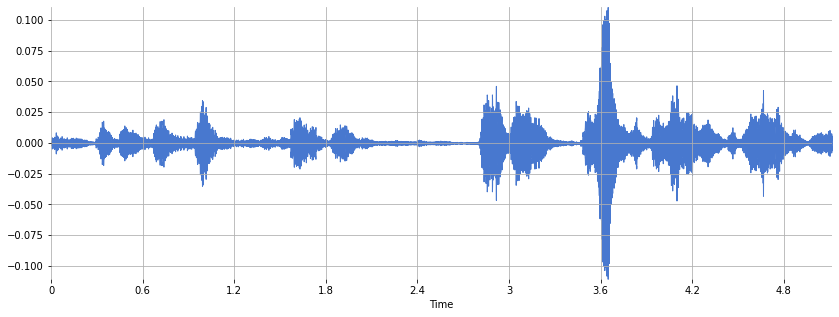

In [35]:
librosa.display.waveplot(x, sr=sr)

TypeError: object of type 'numpy.float32' has no len()

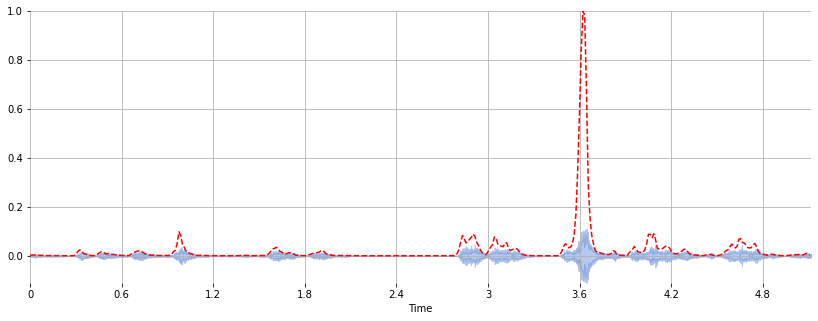

In [36]:
# plot both the energy and RMSE along with the waveform

frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))

While RMSE is the most accurate measure, one thing to note: we percieve loudness differently at different frequencies. So convert the audio to frequency space with an fft (numpy.fft should work great on ~30s of audio). Then compute a power spectral density from this. Weight the PSD by frequency using some loudness curve (Fletcher Munson Curve?). Especially frequencies below 10Hz, since there will be a lot of power there (it would dominate the RMS calculation in the time-domain), yet we can't hear it. Finally, integrate the PSD and take the square root. That'll give you the percieved RMSE.

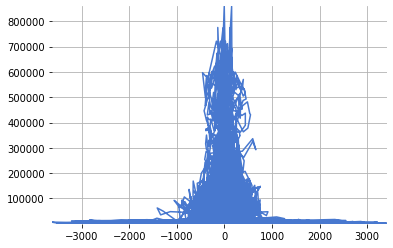

In [37]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np

rate, data = wav.read("chime/clips/S18_U05.CH1-297-7694.wav")
fft_out = fft(data)

%matplotlib inline
plt.plot(data, np.abs(fft_out))
plt.show()